# Projet de prédiction des données liées au Covid

Imports

In [3]:
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
df_raw_confirmed_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df_raw_deaths_global = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df_raw_vaccination_global = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")
df_raw_vaccination_global=df_raw_vaccination_global.drop(columns=["daily_vaccinations_per_million","total_boosters_per_hundred","daily_vaccinations_raw","total_boosters","people_fully_vaccinated_per_hundred","daily_people_vaccinated_per_hundred","people_vaccinated", "total_vaccinations", "daily_people_vaccinated", "people_fully_vaccinated","total_vaccinations_per_hundred","people_vaccinated_per_hundred"])


In [5]:
# Choose latitude and longitude for the chosen country
lat_min = 41.317
lat_max = 51.07167
long_min = -5.14028
long_max = 9.51333

In [6]:
# Function to filter elements by latitude/longitude
def check_lat_long(df, lat_min, lat_max, long_min, long_max):
   return df[(df["Lat"] > lat_min) & (df["Lat"] < lat_max) & (df["Long"] > long_min) & (df["Long"] < long_max)]

In [23]:
country = "Canada"

df_raw_confirmed_country = df_raw_confirmed_global[(df_raw_confirmed_global["Country/Region"] == country) & (df_raw_confirmed_global["Province/State"] == "Quebec")]
df_raw_deaths_country = df_raw_deaths_global[df_raw_deaths_global["Country/Region"] == country]
df_raw_vaccination_country = df_raw_vaccination_global[df_raw_vaccination_global["location"] == country]
df_confirmed_country = df_raw_confirmed_country
df_deaths_country = df_raw_deaths_country
df_vaccination_country = df_raw_vaccination_country.drop(columns=["location","iso_code","date"])
df_confirmed_country 
df_vaccination_country
#df_confirmed_country = check_lat_long(df_raw_confirmed_country, lat_min ,lat_max ,long_min, long_max)
#df_deaths_country = check_lat_long(df_raw_deaths_country, lat_min, lat_max, long_min, long_max)

,daily_vaccinations
9978,NaN
9979,722.0
9980,1506.0
9981,2421.0
9982,2818.0
...,...
10322,57237.0
10323,53870.0
10324,53011.0
10325,55287.0


In [8]:
uselessColumns = ["Lat", "Long", "Province/State", "Country/Region"]

def columnsInNumbers(df):
  df.columns = [i for i in range(len(df_confirmed_country.columns))]

df_confirmed_country = df_confirmed_country.drop(columns=uselessColumns)
df_deaths_country = df_deaths_country.drop(columns=uselessColumns)

columnsInNumbers(df_confirmed_country)
columnsInNumbers(df_deaths_country)


df_confirmed_country

,0,1,2,3,4,5,6,7,8,9,...,667,668,669,670,671,672,673,674,675,676
51,0,0,0,0,0,0,0,0,0,0,...,437548,438363,439070,439762,440461,441343,443547,444584,445755,446630


In [9]:
def get_values_and_days(df):
  return (df.values[0], df.columns.to_list())

confirmed_country_values, confirmed_country_days = get_values_and_days(df_confirmed_country)
deaths_country_values, deaths_country_days = get_values_and_days(df_deaths_country)
vaccination_index_values = list(df_raw_vaccination_country.daily_vaccinations)[:len(confirmed_country_values)]
vaccination_index_days = [i for i in range(df_raw_vaccination_country.date.size)]


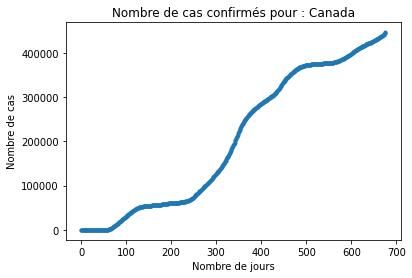

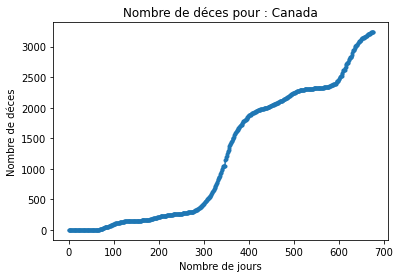

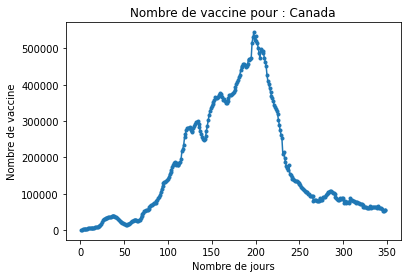

In [10]:
plt.plot(confirmed_country_days, confirmed_country_values, '.-')
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

plt.plot(deaths_country_days, deaths_country_values, '.-')
plt.title("Nombre de déces pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de déces")
plt.show()

plt.plot(vaccination_index_days, vaccination_index_values, '.-')
plt.title("Nombre de vaccine pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de vaccine")
plt.show()

Training and test sets


In [11]:
from sklearn.model_selection import train_test_split

confirmed_train, confirmed_test, confirmed_train_days, confirmed_test_days = train_test_split(confirmed_country_values, confirmed_country_days, test_size=0.30, shuffle=False)
deaths_train, deaths_test, deaths_train_days, deaths_test_days = train_test_split(deaths_country_values, deaths_country_days, test_size=0.30, shuffle=False)

# Regression polynomiale (degré = 2)

In [12]:
import numpy as np
from sklearn import svm

In [13]:
def regression(X, Y):
  reg = svm.SVR(kernel='poly', C=1000, degree=2)
  reg.fit(X, Y)
  return reg

reg_confirmed = regression(np.reshape(confirmed_train_days, newshape=(-1, 1)), confirmed_train)
reg_deaths = regression(np.reshape(deaths_train_days, newshape=(-1, 1)), deaths_train)

print("Regression cas : ", reg_confirmed.score(np.reshape(confirmed_test_days, newshape=(-1, 1)), confirmed_test))
print("Regression morts : ", reg_deaths.score(np.reshape(deaths_test_days, newshape=(-1, 1)), deaths_test))

Regression cas :  -57.4941867529062
Regression morts :  -5.335976581161403


Visualisation des modèles

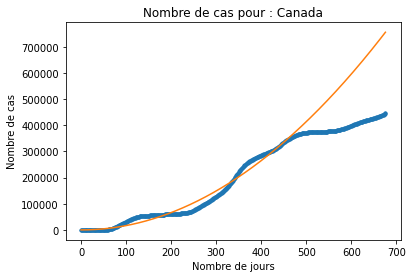

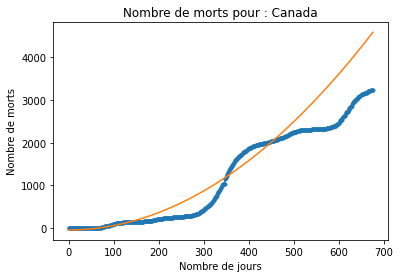

In [14]:
def display_plot(reg, X, Y, ord_context):
  plt.plot(X, Y, '.-')
  plt.plot(X, reg.predict(X), "-")
  plt.title("Nombre de " + ord_context + " pour : " + country)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()

display_plot(reg_confirmed, np.reshape(confirmed_country_days, newshape=(-1, 1)), confirmed_country_values, "cas")
display_plot(reg_deaths, np.reshape(deaths_country_days, newshape=(-1, 1)), deaths_country_values, "morts")

# Réseaux LSTM

In [15]:
import tensorflow as tf
import keras as kr
from sklearn.preprocessing import MinMaxScaler

In [16]:
def create_sequences(data, time_steps=1):
  dataX, dataY = [], []
  for i in range(len(data)-time_steps):
    a = data[i:(i+time_steps)]
    dataX.append(a)
    dataY.append(data[i + time_steps][0])
  return np.array(dataX), np.array(dataY)

def create_lstm_sets(X, time_steps=1, scale=True, train_percent=0.75):
  scaler=None
  if scale:
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(X)
    scaled_X = scaler.transform(X)
  else:
    scaled_X = np.array(X)
  train_size = int(len(scaled_X) * train_percent)
  test_size = len(scaled_X) - train_size
  train, test = scaled_X[0:train_size,:], scaled_X[train_size:len(scaled_X),:]
  return create_sequences(train, time_steps), create_sequences(test, time_steps), scaler

def lstm_network(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(100, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.3))
  model.add(kr.layers.LSTM(100))
  model.add(kr.layers.Dropout(0.3))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=50, batch_size=6);
  return model

## Variable monodimensionelle

In [17]:
time_steps = 1
n_features = 1

### Nombre de cas

In [18]:
confirmed_lstm_set = df_confirmed_country.values[0]
confirmed_lstm_set = np.reshape(confirmed_lstm_set, (len(confirmed_lstm_set), 1))

confirmed_train, confirmed_test, confirmed_scaler = create_lstm_sets(confirmed_lstm_set, time_steps)

confirmed_trainX, confirmed_trainY = confirmed_train
confirmed_testX, confirmed_testY = confirmed_test

confirmed_lstm = lstm_network(confirmed_trainX, confirmed_trainY, time_steps)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
85/85 [==============================] 

### Nombre de morts

In [19]:
deaths_lstm_set = df_deaths_country.values[0]
deaths_lstm_set = np.reshape(deaths_lstm_set, (len(deaths_lstm_set), 1))

deaths_train, deaths_test, deaths_scaler = create_lstm_sets(deaths_lstm_set, time_steps)
deaths_trainX, deaths_trainY = deaths_train
deaths_testX, deaths_testY = deaths_test

deaths_lstm = lstm_network(deaths_trainX, deaths_trainY, time_steps)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 100)            40800     
                                                                 
 dropout_2 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
85/85 [==============================

In [25]:
vaccination_lstm_set = df_vaccination_country["daily_vaccinations"].tolist()
vaccination_lstm_set = np.reshape(vaccination_lstm_set, (len(vaccination_lstm_set), 1))

vaccination_train, vaccination_test, vaccination_scaler = create_lstm_sets(vaccination_lstm_set, time_steps)

vaccination_trainX, vaccination_trainY = vaccination_train
vaccination_testX, vaccination_testY = vaccination_test

vaccination_lstm = lstm_network(vaccination_trainX, vaccination_trainY, time_steps)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 100)            40800     
                                                                 
 dropout_6 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 [==============================

### Affichage des résultats

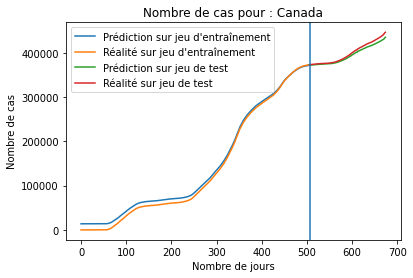

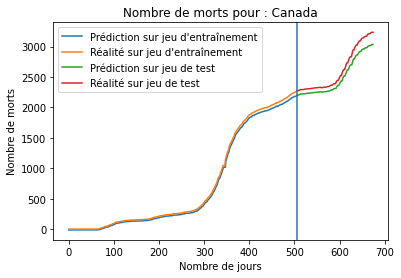

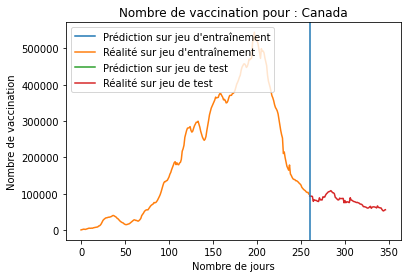

In [26]:
def display_plot_lstm(model, scaler, trainX, trainY, testX, testY, country, ord_context):
  daysTrain = range(len(trainX))
  daysTest = np.array(range(len(testX))) + len(daysTrain)
  plt.plot(daysTrain, scaler.inverse_transform(model.predict(trainX)), '-', label="Prédiction sur jeu d'entraînement")
  plt.plot(daysTrain, scaler.inverse_transform(np.reshape(trainY, (-1, 1))), '-', label="Réalité sur jeu d'entraînement")

  plt.plot(daysTest, scaler.inverse_transform(model.predict(testX)), '-', label="Prédiction sur jeu de test")
  plt.plot(daysTest, scaler.inverse_transform(np.reshape(testY, (-1, 1))), '-', label="Réalité sur jeu de test")

  plt.axvline(len(trainX), 0, 1)
  plt.legend()
  plt.title("Nombre de " + ord_context + " pour : " + country)
  plt.xlabel("Nombre de jours")
  plt.ylabel("Nombre de " + ord_context)
  plt.show()

display_plot_lstm(confirmed_lstm, confirmed_scaler, confirmed_trainX, confirmed_trainY, confirmed_testX, confirmed_testY, country, "cas")
display_plot_lstm(deaths_lstm, deaths_scaler, deaths_trainX, deaths_trainY, deaths_testX, deaths_testY, country, "morts")
display_plot_lstm(vaccination_lstm, vaccination_scaler, vaccination_trainX, vaccination_trainY, vaccination_testX, vaccination_testY, country, "vaccination")

In [ ]:
days = 120
predictions = []
test = [[0.5]]
print(test)
start_day = len(confirmed_trainX)
print(start_day)
for i in range(days):
    pred = confirmed_lstm.predict(test)
    predictions.append(pred)
    test = pred
    print(test)

[[0.5]]
506
[[0.4828015]]
[[0.46656108]]
[[0.45119035]]
[[0.4366119]]
[[0.4227571]]
[[0.40956634]]
[[0.396986]]
[[0.38496864]]
[[0.37347198]]
[[0.36245775]]
[[0.3518917]]
[[0.3417431]]
[[0.33198392]]
[[0.3225888]]
[[0.31353468]]
[[0.30480057]]
[[0.29636678]]
[[0.288216]]
[[0.28033164]]
[[0.2726992]]
[[0.26530457]]
[[0.2581353]]
[[0.2511794]]
[[0.24442595]]
[[0.2378647]]
[[0.23148632]]
[[0.22528201]]
[[0.21924365]]
[[0.21336356]]
[[0.20763454]]
[[0.20204985]]
[[0.19660315]]
[[0.19128868]]
[[0.18610087]]
[[0.18103436]]
[[0.17608425]]
[[0.17124593]]
[[0.16651502]]
[[0.16188756]]
[[0.15735939]]
[[0.15292683]]
[[0.14858648]]
[[0.14433494]]
[[0.14016908]]
[[0.13608599]]
[[0.13208264]]
[[0.12815648]]
[[0.12430489]]
[[0.12052533]]
[[0.11681545]]
[[0.11317316]]
[[0.10959631]]
[[0.10608283]]
[[0.10263079]]
[[0.09923837]]
[[0.09590364]]
[[0.09262505]]
[[0.08940095]]
[[0.0862298]]
[[0.08311006]]
[[0.08004028]]
[[0.07701907]]
[[0.07404515]]
[[0.07111725]]
[[0.06823412]]
[[0.0653946]]
[[0.06259759]]

# Variables multi-dimensionnelles

In [ ]:
time_steps = 12
n_features = 2

### Get new data


In [ ]:
df_raw_stringency_index = pd.read_csv("covid-stringency-index.csv")
df_raw_stringency_index_country = df_raw_stringency_index[df_raw_stringency_index["Entity"] == country]
df_stringency_index_country = df_raw_stringency_index_country.drop(columns=["Entity", "Code"])
df_stringency_index_country.drop(index=df_stringency_index_country.index[0], axis=0, inplace=True)

stringency_index_values = list(df_stringency_index_country.stringency_index)[:len(confirmed_country_values)]
stringency_index_days = [i for i in range(df_stringency_index_country.Day.size)]

### Adjust some data length (all equal)

In [ ]:
confirmed_country_values = confirmed_country_values[:len(stringency_index_values)]
confirmed_country_days = confirmed_country_days[:len(stringency_index_values)]

deaths_country_values = deaths_country_values[:len(stringency_index_values)]
deaths_country_days = deaths_country_days[:len(stringency_index_values)]

### Print on a plot

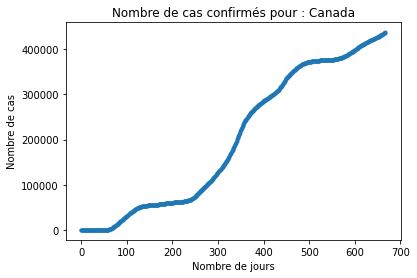

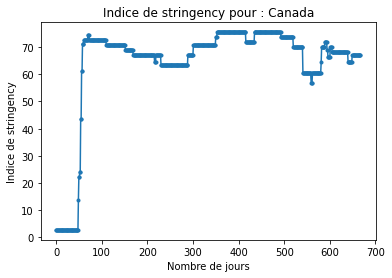

In [ ]:
plt.plot(confirmed_country_days, confirmed_country_values, '.-')
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()

plt.plot(stringency_index_days, stringency_index_values, '.-')
plt.title("Indice de stringency pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Indice de stringency")
plt.show()

### Create data sets

In [ ]:
# Scaled values
confirmed_scaler = MinMaxScaler((-1, 1))
deaths_scaler = MinMaxScaler((-1, 1))
stringency_scaler = MinMaxScaler((-1, 1))

confirmed_scaler.fit(confirmed_country_values.reshape((-1, 1)))
scaled_confirmed = confirmed_scaler.transform(confirmed_country_values.reshape((-1, 1))).reshape((-1,))

deaths_scaler.fit(deaths_country_values.reshape((-1, 1)))
scaled_deaths = deaths_scaler.transform(deaths_country_values.reshape((-1, 1))).reshape((-1,))

stringency_scaler.fit(np.array(stringency_index_values).reshape((-1, 1)))
scaled_stringency = stringency_scaler.transform(np.array(stringency_index_values).reshape((-1, 1))).reshape((-1,))

In [ ]:
multi_data = list(zip(scaled_confirmed, scaled_stringency))

In [ ]:
multi_train, multi_test, _ = create_lstm_sets(multi_data, time_steps, scale=False, train_percent=0.70)
multi_trainX, multi_trainY = multi_train
multi_testX, multi_testY = multi_test

In [ ]:
def lstm_network_multi(X, Y, time_steps=1, n_features=1):
  model = kr.Sequential()
  model.add(kr.layers.LSTM(200, input_shape=(time_steps, n_features), return_sequences=True)) #return_sequences=True
  model.add(kr.layers.Dropout(0.1))
  model.add(kr.layers.LSTM(400))
  model.add(kr.layers.Dropout(0.1))
  model.add(kr.layers.Dense(1))
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='mean_squared_error', optimizer=opt)
  model.summary()
  model.fit(X, Y, epochs=20, batch_size=6);
  return model

In [ ]:
multi_lstm = lstm_network_multi(multi_trainX, multi_trainY, time_steps, n_features)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 12, 200)           162400    
                                                                 
 dropout_18 (Dropout)        (None, 12, 200)           0         
                                                                 
 lstm_19 (LSTM)              (None, 400)               961600    
                                                                 
 dropout_19 (Dropout)        (None, 400)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 401       
                                                                 
Total params: 1,124,401
Trainable params: 1,124,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
76/76 [==========================

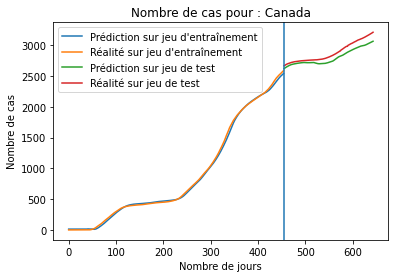

In [ ]:
display_plot_lstm(multi_lstm, deaths_scaler, multi_trainX, multi_trainY, multi_testX, multi_testY, country, "cas")

In [ ]:
n_days = 150
predictions = []
test = multi_trainX[-1]
test = test.reshape(-1, time_steps, n_features)
start_day = len(multi_trainX)
print(start_day)
print(test)
for i in range(n_days):
    pred = multi_lstm.predict(test)
    predictions.append(pred[0][0])
    
    old = test[0][0]
    test = np.delete(test[0], 0, axis=0)

    indice = stringency_scaler.transform([[70]])
    if i > 75:
        indice = stringency_scaler.transform([[80]])

    test = np.append(test, [pred[0][0], indice[0][0]]).reshape(-1, time_steps, n_features)

    print(pred)

455
[[[0.55411063 1.        ]
  [0.55959575 1.        ]
  [0.56459634 1.        ]
  [0.56879245 1.        ]
  [0.57427299 1.        ]
  [0.57834569 1.        ]
  [0.58277492 1.        ]
  [0.58772523 1.        ]
  [0.59261612 1.        ]
  [0.59771271 1.        ]
  [0.60307441 1.        ]
  [0.60727966 1.        ]]]
[[0.5825086]]
[[0.5854563]]
[[0.5872677]]
[[0.58822876]]
[[0.588583]]
[[0.5884095]]
[[0.5878938]]
[[0.58708966]]
[[0.5860213]]
[[0.58472884]]
[[0.58322555]]
[[0.5815155]]
[[0.57967323]]
[[0.57947654]]
[[0.5789741]]
[[0.57827556]]
[[0.5774581]]
[[0.5765741]]
[[0.57566327]]
[[0.5747486]]
[[0.573847]]
[[0.57297105]]
[[0.5721302]]
[[0.57133335]]
[[0.5705871]]
[[0.5698953]]
[[0.56916803]]
[[0.5684298]]
[[0.56769395]]
[[0.5669688]]
[[0.5662581]]
[[0.56556374]]
[[0.5648849]]
[[0.5642213]]
[[0.56357235]]
[[0.5629354]]
[[0.56230944]]
[[0.5616916]]
[[0.56108075]]
[[0.56047934]]
[[0.55988836]]
[[0.5593083]]
[[0.5587391]]
[[0.55818]]
[[0.5576305]]
[[0.5570906]]
[[0.5565596]]
[[0.556037

In [ ]:
predicted_plot = np.concatenate((confirmed_scaler.transform(confirmed_country_values[:start_day].reshape((-1, 1))).reshape((-1,)), predictions))
predicted_plot = confirmed_scaler.inverse_transform(predicted_plot.reshape((-1, 1)))

days = np.concatenate((list(range(start_day)), np.array([day for day in range(start_day, start_day+n_days)])))

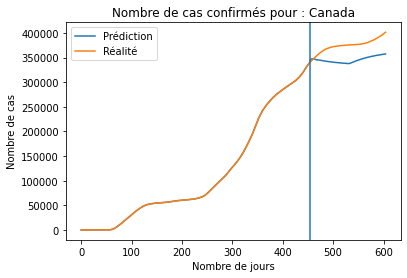

In [ ]:
plt.plot(days, predicted_plot, '-', label="Prédiction")
plt.plot(days, confirmed_country_values[:start_day+n_days], '-', label="Réalité")
plt.legend()
plt.axvline(start_day)
plt.title("Nombre de cas confirmés pour : " + country)
plt.xlabel("Nombre de jours")
plt.ylabel("Nombre de cas")
plt.show()